In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from os import walk
from tensorflow_examples.models.pix2pix import pix2pix
from IPython.display import clear_output

tf.__version__

'2.0.0'

# Running the Brode Cell Images using a MobileNetV2 Model through Tensorflow 
TIFF files are unsupported natively in Tensorflow. Therefore we need to convert to a numpy array and load those image slices to a parallel dataset that way. Parallel Datasets in tensorflow allow us to pass an image and its mask as input and a label. The flow is: Convert TIFF to array -> append arrays as slices -> load by slice into tensorflow dataset. 

While there are 19000 images in the whole set, only 1200 have masks, therefore the images we use are a subset of the whole thing. 

In addition, the tensorflow models we use work better with an RGB image. All these images are grayscale, but we can transform it into RGB by repeating the array 3 times. 

[Dataset can be found here.](https://data.broadinstitute.org/bbbc/BBBC005/)

In [2]:
images = {}
masks = {}
raw_images = {}

# Just for testing and proof of concept, keeping the set small. The ideal is the full dataset, ~1200 images  
DATASET_SIZE = 100

# Whereever the image and mask files are
PARENT_DIRECTORY = "cell_images"

# Useful for slow/large imports, displays the number of images read so far
UPDATE_STATUS = 10

"""
Tranverse the directory. This only works if you have a folder in the PARENT_DIRECTORY, 
titled 'images' and one titled 'masks'. 
Appends the filenames together in a dictionary with 'images' and 'masks'. 

Dictionary contains:
Image class (image or mask):
    parent directory: original directory stated in PARENT_DIRECTORY
    files: list of all the files in that fiolder, should all be TIF
"""
for dir_path, dirname, file_names  in walk(str(PARENT_DIRECTORY)):
    # Prevents .ipynbcheckpoint directoies from getting picked up
    if len(file_names) > 0:
        img_class = dir_path.split("/")[-1]
        raw_images[img_class] = {}
        raw_images[img_class]['parent_directory'] = "/".join(dir_path.split("/")[:-1])
        raw_images[img_class]['files'] = file_names
        print("/".join(dir_path.split("/")[:-1]))

# Image slices for images and masks 
image_slices = []        
mask_slices = []

# We want to randomly choose images from the directory. 
random_index = np.arange(len(raw_images['masks']['files']))
np.random.shuffle(random_index)

# Go through all the mask files, mask is a subset of images, 
# so we only need to read in the images that have a corresponding mask.  
for i, image in enumerate(raw_images['masks']['files']):
    try:
        # Read in image files, and convert to a numpy array
        image_slice = np.array(Image.open(str(raw_images['images']['parent_directory'] +\
                                              "/images/" +\
                                              raw_images['masks']['files'][random_index[i -1]])))
        mask_slice = np.array(Image.open(str(raw_images['images']['parent_directory'] +\
                                             "/masks/" +\
                                             raw_images['masks']['files'][random_index[i -1]])))
        # Resize the numpy arrays to an 'RGB' set, showing the same value repeated 3 times 
        image_slices.append(np.repeat(image_slice[..., np.newaxis], 3, -1))
        
        # Masks are not repeated, they need to remain just a classification for each pixel in range [0,1]
        mask_slices.append(mask_slice[..., np.newaxis])
        
        
        if i%UPDATE_STATUS == 0:
            print(i , "Files Read")
        # Limiting our import 
        if i > DATASET_SIZE:
            break
    except OSError:
        print("Non-TIFF File Found")
        continue


print("Importing Tensor Slices")
raw_dataset = tf.data.Dataset.from_tensor_slices((image_slices, mask_slices))

print("Complete")

cell_images
cell_images
0 Files Read
10 Files Read
20 Files Read
30 Files Read
40 Files Read
50 Files Read
60 Files Read
70 Files Read
80 Files Read
90 Files Read
100 Files Read
Importing Tensor Slices
Complete


# Image preprocessing
Normalize the images to values in range $[0,1]$ and convert the masks to binary arrays. Turns the dataset into a parallel datset similar to the tensorflow parralel dataset  

In [3]:
"""
Image preprocessing 
"""

# Normalize the dataset to [0,1]
def normalize(input_image, input_mask):
    input_image = tf.cast(input_image, tf.float32) / 255.0
    # Mask is binary
    input_mask = int(input_mask / 255)
    return input_image, input_mask

# Resize the pictures to (128,128) and flip some of the training instances to add in variety
@tf.function
def load_image_train(image, mask):
    input_image = tf.image.resize(image, (128, 128))
    input_mask = tf.image.resize(mask, (128, 128))
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

    input_image, input_mask = normalize(input_image, input_mask)

    return input_image, input_mask


# Tensorflow function that iterates a function of all the datapoints. 
full_dataset = raw_dataset.map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Display image and mask together
The image is paried with it's mask for training, just like in the image segmentation tutorial. While the image is "repeated" to become a 3D array, the mask is kept at 1 value for each pixel $x$, is $x \in \{0,1\}$

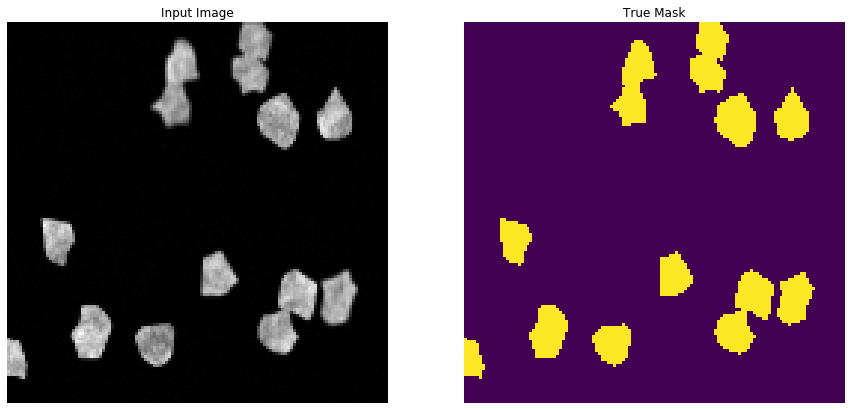

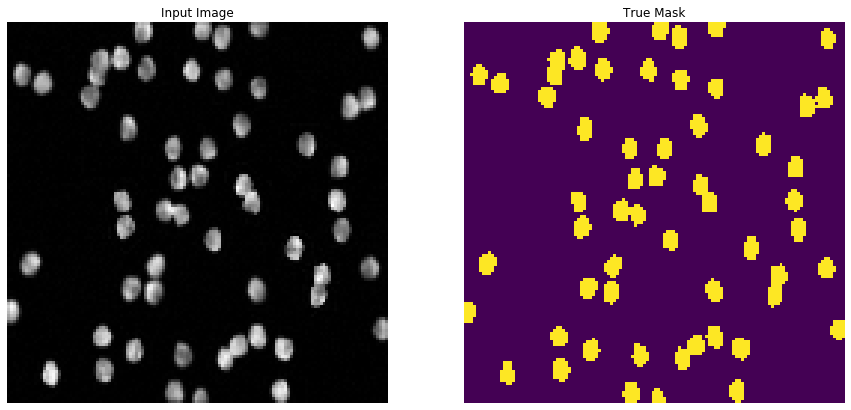

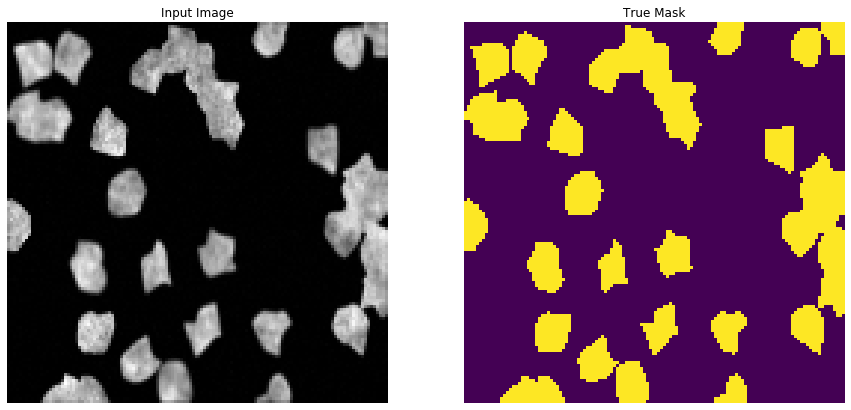

In [4]:
"""
For displaying images. Picks an image from the dataset and displays 
both the original image, it's mask, and the predicted mask when given.
"""
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

for sample_image, sample_mask in full_dataset.take(3):
    display([sample_image, sample_mask])


# Subset the full dataset into the training, validation and testing 
This is maintaining a 60/20/20 training/validation/testing split for the dataset. Tensorflow datasets are weird, we have to take the datapoints, then traverse some iterator that amount and take whaever's left. The way it works is:

1) Shuffle the dataset

2) Take number of training instances from the full datset equal to the training size.

3) Skip the number of instances in the training size and pull the rest as the temporary test samples.

4) Skip the number of test samples and pull the rest as the validation samples. 

The skip function also pulls samples. 

In [5]:
# Set Sizes 
train_size = int(DATASET_SIZE * 0.6)
print(train_size)
test_size = int(DATASET_SIZE * 0.2)
validation_size = int(train_size * 0.2)

# Shuffle and subset
full_dataset = full_dataset.shuffle(DATASET_SIZE)
train_dataset = full_dataset.take(train_size)
test_dataset = full_dataset.skip(train_size)
val_dataset = test_dataset.skip(test_size)
test_dataset = test_dataset.take(test_size)


60


# Build the Model
Used in the tensorflow image tutorial. Basic UNet with 5 downstack layers and 4 upstack with the deconvolution layer at the end.  

In [6]:
OUTPUT_CHANNELS = 2 # Only two options for each channel (1 = cell, 0 = background)

# Downstack model
encoder_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [encoder_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model (encoding)
down_stack = tf.keras.Model(inputs=encoder_model.input, outputs=layers)

down_stack.trainable = False

# Decoding layers
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

"""
The UNet model, compiles and adds in the layers built above. 
"""
def unet_model(output_channels):

  # This is the last layer of the model
    last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same', 
        activation='softmax'
#     activation = 'relu'
    )  #64x64 -> 128x128

    
    inputs = tf.keras.layers.Input(shape=[128, 128, 3])
    x = inputs

    # Downsampling through the model add encoders
    skips = down_stack(x)
    x = skips[-1]
    skips = reversed(skips[:-1])

      # Upsampling and establishing the skip connections (decoders)
    for up, skip in zip(up_stack, skips):
        x = up(x)
        concat = tf.keras.layers.Concatenate()
        x = concat([x, skip])

    x = last(x)

    return tf.keras.Model(inputs=inputs, outputs=x)

## Testing with prescision/recall
Originally we thought the classes as imbalanced, so we build this function, which uses the F1 score as the metric to test model performance. 

In [7]:
"""
Area under curve for looking at precicion/recall for model performance. 
This is for imbalanced classes, however, we do not think it's useful since the 
images with a lot of cells are not imbalanced.  
"""
def AUC(y_true, y_pred):
    true_positives = tf.keras.backend.sum(tf.floor((y_true + y_pred) * 0.5))
    p = true_positives/tf.keras.backend.sum(y_pred + tf.keras.backend.epsilon())
    r = true_positives/tf.keras.backend.sum(y_true + tf.keras.backend.epsilon())
    return 2*((p * r)/(r + p))

# CNN Model 
Build the UNet, set the optimizer and the metrics, and define the loss function. 

In [11]:
trained_model = unet_model(OUTPUT_CHANNELS)
trained_model.compile(optimizer='adam', 
                      loss='sparse_categorical_crossentropy',
#                       loss = 'binary_crossentropy',
              metrics=['accuracy'])

# Visualization and untrained model 
Following the tutorial, this shows the mask generated with an untrainined model on own images

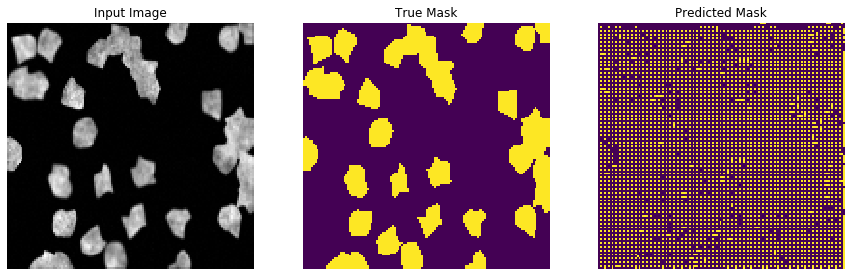

In [9]:
# Build the predicted mask
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

# Show the original image, the mask, and the predicted mask. 
def show_predictions(dataset=None, num=1):
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = trained_model.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
            create_mask(trained_model.predict(sample_image[tf.newaxis, ...]))])

        
show_predictions()

# Undergo training and display predicted masks 
Now train the model. Number of epochs is kept at 20, but we can adjust this later if need be.  

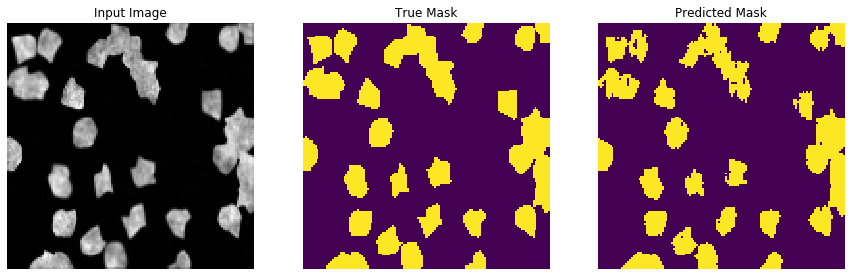


Sample Prediction after epoch 20

60/60 [==============================] - 9s 150ms/step - loss: 0.0120 - accuracy: 0.9964 - val_loss: 0.2097 - val_accuracy: 0.9294


In [12]:
class DisplayCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        show_predictions()
        print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

# With only 100 images, we'll keep the batch size small
BATCH_SIZE = 1        
        
# The model requires the input to have shape (iteration, height, width, channel), 
# so this is cacheing, and batching. 
if len(train_dataset._flat_shapes[0]) < 4:
    train_dataset = train_dataset.cache().batch(BATCH_SIZE).repeat()
    train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
if len(val_dataset._flat_shapes[0]) < 4:
    val_dataset = val_dataset.batch(BATCH_SIZE)
    test_dataset = test_dataset.batch(BATCH_SIZE)



    
# Number of iterations through the dataset
EPOCHS = 20
VALIDATION_STEPS = validation_size//BATCH_SIZE
STEPS_PER_EPOCH = train_size//BATCH_SIZE

# Class weight for exploring imbalanced sets, not implemented. 
class_weights = {0:0.11,
                1:0.89}

model_history = trained_model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_dataset,
                          callbacks=[DisplayCallback()], 
#                                  class_weight = class_weights,
                                 )

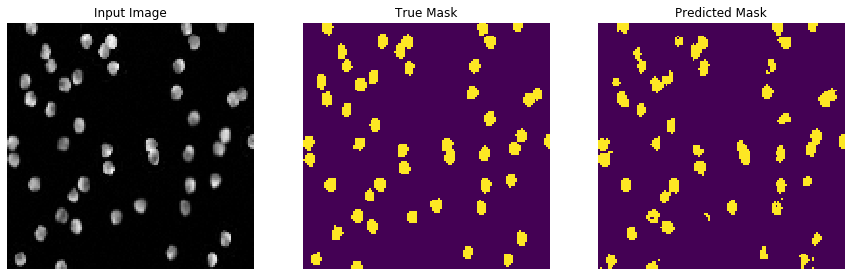

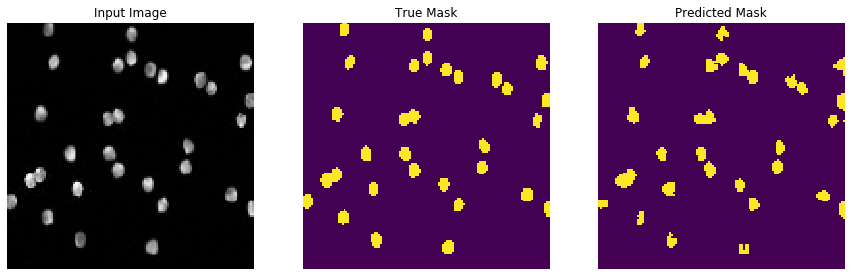

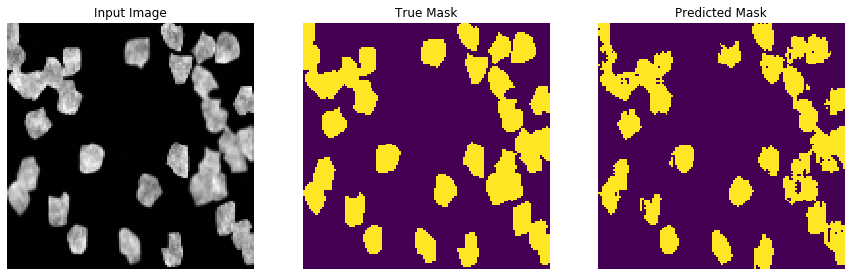

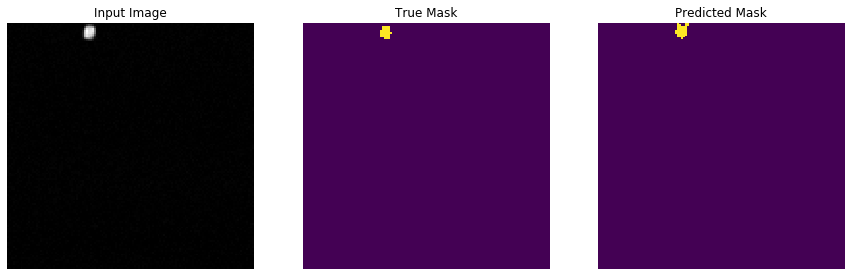

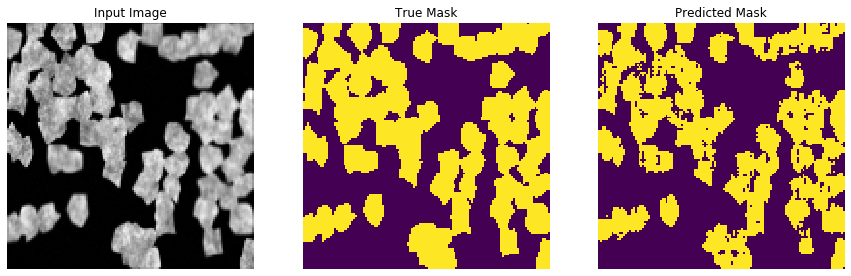

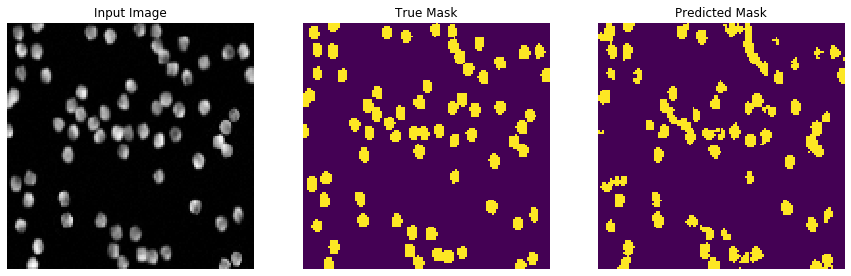

In [13]:
if len(test_dataset._flat_shapes[0]) < 4:
    test_dataset = test_dataset.batch(1)


show_predictions(test_dataset, 6)

# Loss during training

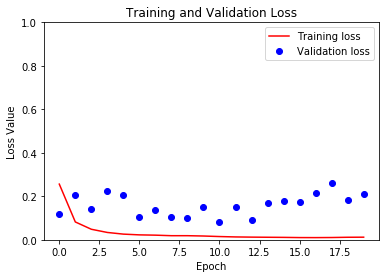

In [14]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()

# Accuracy on test data

In [17]:
test_history = trained_model.evaluate(test_dataset)

print("Loss for test data: {}, \nAccuracy on test data: {}".format(test_history[0], test_history[1]))

20/20 [==============================] - 1s 61ms/step - loss: 0.1513 - accuracy: 0.9502
Loss for test data: 0.1513342655845918, 
Accuracy on test data: 0.9502410888671875
